In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import GridSearchCV

In [5]:
# Load the data
X_train = pd.read_csv('X_train_Wwou3IE.csv')
y_train = pd.read_csv('y_train_jJtXgMX.csv')

In [6]:
# Merge X_train and y_train on DELIVERY_START for further analysis
train_data = pd.merge(X_train, y_train, on="DELIVERY_START")

# Display the first few rows of the training data
train_data.head()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,spot_id_delta
0,2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,NaN,-36.874770
1,2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.0,NaN,-12.643588
2,2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.0,NaN,-1.950193
3,2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.0,NaN,1.938272
4,2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.0,NaN,0.199907


In [7]:
# Check the proportion of missing values in each column
round(X_train.isna().sum()/X_train.shape[0]*100,2)

DELIVERY_START                    0.00
load_forecast                    12.14
coal_power_available              0.01
gas_power_available               0.01
nucelear_power_available          0.01
wind_power_forecasts_average      0.23
solar_power_forecasts_average     0.23
wind_power_forecasts_std          0.23
solar_power_forecasts_std         0.23
predicted_spot_price             82.59
dtype: float64

The 'predicted_spot_price' represents the price generated by Elmy's prediction algorithm. Since we have only ~20% of the information and aim to use a simple predictive algorithm, we will remove this column

In [8]:
# Drop "predicted_spot_price" column
train_data_cleaned = train_data.drop(columns=["predicted_spot_price"])

# Drop rows with missing values
train_data_cleaned = train_data_cleaned.dropna()

# Check the size of the cleaned data
train_data_cleaned.shape

(9269, 10)

For the initial study, we will restrict ourselves to adding only time-related features.

In [3]:
def preprocess_data(df):
    # Ensure 'DELIVERY_START' is set as the index with timezone handling
    df['DELIVERY_START'] = pd.to_datetime(df['DELIVERY_START'], utc=True)  # Parse with timezone info
    df = df.set_index('DELIVERY_START')
    df.index = df.index.tz_convert('Europe/Berlin')  # Adjust to desired timezone, if needed

    # Add time-related features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['dayofmonth'] = df.index.day

    # We can add these features as well 
    #train_data_cleaned['weekofyear'] = train_data_cleaned.index.isocalendar().week
    #train_data_cleaned['dayofyear'] = train_data_cleaned.index.dayofyear
    return df 

In [7]:
train_data_cleaned_proc=preprocess_data(train_data_cleaned)
train_data_cleaned_proc.columns

Index(['load_forecast', 'coal_power_available', 'gas_power_available',
       'nucelear_power_available', 'wind_power_forecasts_average',
       'solar_power_forecasts_average', 'wind_power_forecasts_std',
       'solar_power_forecasts_std', 'spot_id_delta', 'hour', 'dayofweek',
       'month', 'year', 'quarter', 'dayofmonth'],
      dtype='object')

To begin, we will use a Random Forest model with the following parameters: n_estimators=1000 and random_state=4.

In [8]:
# Define features and target
X = train_data_cleaned_proc.drop(columns=["spot_id_delta"])
y = train_data_cleaned_proc["spot_id_delta"]

# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Feature importance
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("\nFeature Importances:")
print(feature_importance_df)

Mean Squared Error: 240.04772989659523
R^2 Score: 0.7129205144370647

Feature Importances:
                          Feature  Importance
0        nucelear_power_available    0.219836
1                   load_forecast    0.210907
2    wind_power_forecasts_average    0.089273
3                      dayofmonth    0.081579
4        wind_power_forecasts_std    0.070076
5                           month    0.057158
6                       dayofweek    0.053853
7                            hour    0.047268
8       solar_power_forecasts_std    0.046989
9                         quarter    0.043216
10  solar_power_forecasts_average    0.035043
11            gas_power_available    0.031757
12           coal_power_available    0.009279
13                           year    0.003764


In [9]:
# Read the test data
test_data = pd.read_csv('X_test_GgyECq8.csv')

# Check the proportion of missing values in each column
round(test_data.isna().sum()/test_data.shape[0]*100,2)

DELIVERY_START                    0.00
load_forecast                     0.00
coal_power_available              0.00
gas_power_available               0.00
nucelear_power_available          0.00
wind_power_forecasts_average      0.00
solar_power_forecasts_average     0.49
wind_power_forecasts_std          0.00
solar_power_forecasts_std         0.49
predicted_spot_price             31.08
dtype: float64

In [10]:
# Drop "predicted_spot_price" column from the test data
test_data_cleaned = test_data.drop(columns=["predicted_spot_price"])

# Fill missing values with 0
test_data_cleaned = test_data_cleaned.fillna(0)

test_data_cleaned.shape

(4942, 9)

In [11]:
# Preprocess the test data
test_data_cleaned_proc = preprocess_data(test_data_cleaned)

# Make predictions 
y_pred_final = model.predict(test_data_cleaned_proc)

# Create a panda file, add the "DELIVERY_START" column
predictions = pd.DataFrame(y_pred_final, columns=["spot_id_delta"])
predictions.insert(0, "DELIVERY_START", test_data["DELIVERY_START"])
predictions.head()

# Save to CSV
predictions.to_csv('predictions1.csv', index=False)

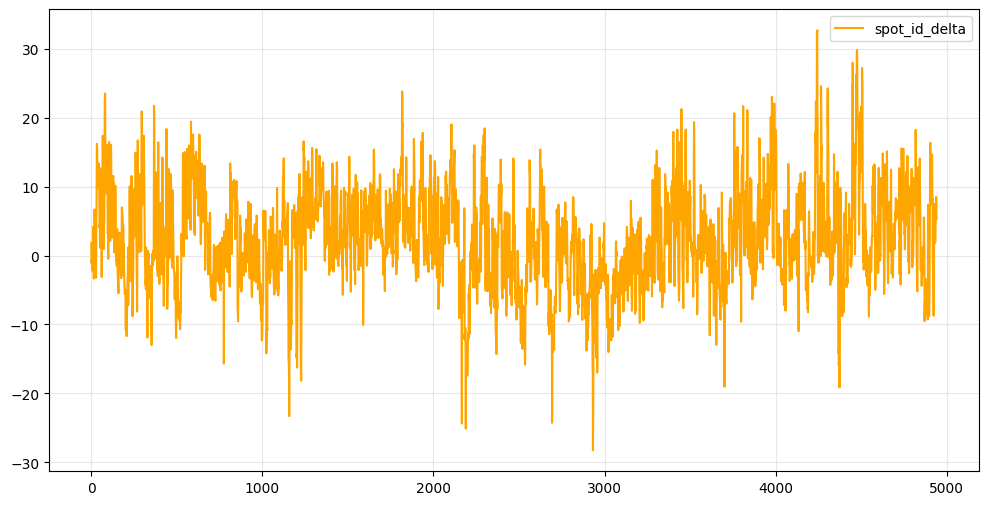

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(predictions['spot_id_delta'], color='orange', label='spot_id_delta')
plt.grid(alpha=0.3)
plt.legend(fontsize=10)
plt.show()


The score of the Random Forest model with parameters (1000,42) is 0,562080

### Optimize the model using GridSearchCV


In [16]:
# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

# Define features and target, split the data
X = train_data_cleaned_proc.drop(columns=["spot_id_delta"])
y = train_data_cleaned_proc["spot_id_delta"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimator

In [24]:
# Define the optimized Random Forest model
rf_opt = RandomForestRegressor(
    max_depth=None, 
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=2, 
    n_estimators=500, 
    random_state=42,
    n_jobs=-1  # Use all available CPU cores for faster training
)

# Train the model
rf_opt.fit(X_train, y_train)

# Make predictions
y_pred_opt = rf_opt.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred_opt)
mse = mean_squared_error(y_test, y_pred_opt)
rmse = mean_squared_error(y_test, y_pred_opt)
r2 = r2_score(y_test, y_pred_opt)

# Print evaluation metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2}")

MAE: 9.9823
MSE: 260.2000
RMSE: 260.2000
R^2 Score: 0.6888198180790309


In [23]:
# Make predictions 
y_pred_opt_final = rf_opt.predict(test_data_cleaned_proc)

# Create a panda file, add the "DELIVERY_START" column
predictions2 = pd.DataFrame(y_pred_opt_final, columns=["spot_id_delta"])
predictions2.insert(0, "DELIVERY_START", test_data["DELIVERY_START"])

# Save to CSV
predictions2.to_csv('predictions2.csv', index=False)

The score of the optimized model is : 0,543616, it is lower than the score of the initial model.

### Inscreasing the number of estimators

In [28]:
# Initialize and train the Random Forest model
model_inc = RandomForestRegressor(n_estimators=3000, random_state=42)
model_inc.fit(X_train, y_train)

RandomForestRegressor(n_estimators=3000, random_state=42)

In [29]:
# Make predictions 
y_pred_inc = model_inc.predict(test_data_cleaned_proc)

# Create a panda file, add the "DELIVERY_START" column
predictions3 = pd.DataFrame(y_pred_inc, columns=["spot_id_delta"])
predictions3.insert(0, "DELIVERY_START", test_data["DELIVERY_START"])

# Save to CSV
predictions3.to_csv('predictions3.csv', index=False)

The score of the Random Forest model with parameters (3000,42) is 0,5627820. It is slightly better than the model with parameters (1000,42).